# EarthMIP Trial

**Installation**

* [apex](https://github.com/NVIDIA/apex#quick-start)

In [1]:
import numpy as np
import cdsapi
from pathlib import Path
import autoroot
import datetime
from earth2mip import inference_ensemble, registry
from earth2mip.networks import get_model
from earth2mip.initial_conditions import cds
from earth2mip.inference_ensemble import run_basic_inference
import matplotlib.pyplot as plt
from bayesevt._src.data.ics import LocalDataSource

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Model

In [2]:
model_name = "fcnv2_sm" # "fcn" # 
model = f"e2mip://{model_name}"
device = "cpu"

In [3]:
time_loop  = get_model(
    model=model,
    device=device,
)

channel_names = time_loop.in_channel_names

In [4]:
channel_names

['u10m',
 'v10m',
 'u100m',
 'v100m',
 't2m',
 'sp',
 'msl',
 'tcwv',
 'u50',
 'u100',
 'u150',
 'u200',
 'u250',
 'u300',
 'u400',
 'u500',
 'u600',
 'u700',
 'u850',
 'u925',
 'u1000',
 'v50',
 'v100',
 'v150',
 'v200',
 'v250',
 'v300',
 'v400',
 'v500',
 'v600',
 'v700',
 'v850',
 'v925',
 'v1000',
 'z50',
 'z100',
 'z150',
 'z200',
 'z250',
 'z300',
 'z400',
 'z500',
 'z600',
 'z700',
 'z850',
 'z925',
 'z1000',
 't50',
 't100',
 't150',
 't200',
 't250',
 't300',
 't400',
 't500',
 't600',
 't700',
 't850',
 't925',
 't1000',
 'r50',
 'r100',
 'r150',
 'r200',
 'r250',
 'r300',
 'r400',
 'r500',
 'r600',
 'r700',
 'r850',
 'r925',
 'r1000']

## Initial Condition

In [5]:
# starting timestep
t0 = datetime.datetime(2021,8,1)
# number of forecast steps
num_steps = 10 # 6h intervals

In [6]:
from bayesevt._src.dtypes.time import Time

In [9]:
import xarray as xr
# Variables
cloud_dir = "gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr"
local_dir = "/pool/proyectos/CLINT/sa4attrs/data/raw/2021_08_01-full_37-1h-0p25deg-chunk-1.zarr"
# Derived Variables
ds = xr.open_zarr(cloud_dir)
ds

<xarray.Dataset>
Dimensions:                                           (time: 93544,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 13)
Coordinates:
  * latitude                                          (latitude) float32 90.0...
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float32 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_wind_speed                                    (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_dewpoint_temperature                           (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    above_ground                                      (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    ...                                                ...
    volumetric_soil_water_layer_1                     (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_2                     (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_3                     (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_4                     (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    vorticity                                         (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    wind_speed                                        (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>

In [10]:
ds = ds.sel(time="2021-08-01")
ds

<xarray.Dataset>
Dimensions:                                           (time: 4, latitude: 721,
                                                       longitude: 1440,
                                                       level: 13)
Coordinates:
  * latitude                                          (latitude) float32 90.0...
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float32 0.0...
  * time                                              (time) datetime64[ns] 2...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_wind_speed                                    (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_dewpoint_temperature                           (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    above_ground                                      (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    ...                                                ...
    volumetric_soil_water_layer_1                     (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_2                     (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_3                     (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_4                     (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    vorticity                                         (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    wind_speed                                        (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>

In [11]:
ds.to_zarr("/pool/proyectos/CLINT/sa4attrs/data/raw/2021_08_01-wb13-6h-1440x721_with_derived_variables.zarr")

### Download Manually

In [25]:
from bayesevt._src.data.era5.ops import parse_single_levels, parse_pressure_levels
from bayesevt._src.dtypes.grid import Grid, RES025
from bayesevt._src.dtypes.region import Region, GLOBE

# save path
raw_data_path = "/pool/proyectos/CLINT/sa4attrs/data/raw"

# create a custom time variable
time = Time(year=2021, month=8, day=1)

# parse all variables
sl_variables = parse_single_levels(channel_names)

# parse pressure level variables
pl_variables = parse_pressure_levels(channel_names)

In [26]:
sl_variables

[SingleLevelCode(id=165, name='u10m'),
 SingleLevelCode(id=166, name='v10m'),
 SingleLevelCode(id=228246, name='u100m'),
 SingleLevelCode(id=228247, name='v100m'),
 SingleLevelCode(id=167, name='t2m'),
 SingleLevelCode(id=134, name='sp'),
 SingleLevelCode(id=151, name='msl'),
 SingleLevelCode(id=137, name='tcwv')]

#### Single Levels

We can download the single level request for the CDSAPI by generating a request≥

In [27]:
import pprint
from bayesevt._src.data.era5.download import (
    create_request_single_level, 
    create_request_pressure_level,
    create_request_single_level_multi,
    create_request_pressure_level_multi
)


dataset, request, save_name = create_request_single_level_multi(
    sl_variables, 
    time=time,
    region=GLOBE,
    grid=RES025,
    save_format="grib"
    
)
dataset, pprint.pprint(request), save_name

{'area': (90, -180, -90, 180),
 'day': ['01'],
 'format': 'grib',
 'grid': (0.25, 0.25),
 'month': ['08'],
 'param': '167/228247/134/165/166/228246/137/151',
 'product_type': 'reanalysis',
 'time': ['00:00'],
 'year': ['2021']}


('reanalysis-era5-single-levels', None, 'reanalysis-20210801-00:00-sl.grib')

In [28]:
save_path = Path(raw_data_path).joinpath(f"{model_name.replace('_', '')}_{save_name}")
save_path

PosixPath('/pool/proyectos/CLINT/sa4attrs/data/raw/fcnv2sm_reanalysis-20210801-00:00-sl.grib')

In [29]:
# c = cdsapi.Client()
# c.retrieve(dataset, request, save_path) 

#### Pressure Levels

In [30]:

dataset, request, save_name = create_request_pressure_level_multi(
    pl_variables, 
    time=time,
    region=GLOBE,
    grid=RES025,
    save_format="grib"
    
)
dataset, pprint.pprint(request), save_name

{'area': (90, -180, -90, 180),
 'day': ['01'],
 'format': 'grib',
 'grid': (0.25, 0.25),
 'month': ['08'],
 'param': '130/132/129/157/131',
 'pressure_level': [100,
                    200,
                    1000,
                    300,
                    400,
                    50,
                    850,
                    500,
                    150,
                    600,
                    250,
                    700,
                    925],
 'product_type': 'reanalysis',
 'time': ['00:00'],
 'year': ['2021']}


('reanalysis-era5-pressure-levels', None, 'reanalysis-20210801-00:00-pl.grib')

In [31]:
save_path = Path(raw_data_path).joinpath(f"{model_name.replace('_', '')}_{save_name}")
save_path

PosixPath('/pool/proyectos/CLINT/sa4attrs/data/raw/fcnv2sm_reanalysis-20210801-00:00-pl.grib')

In [32]:
# c = cdsapi.Client()
# c.retrieve(dataset, request, save_path) 

### Load Saved IC

Now that we have downloaded the IC, we can load the file to be used as the initial condition.



In [33]:
FILE_PATHS = {
    "fcnv2_sm": [
    "/pool/proyectos/CLINT/sa4attrs/data/raw/fcnv2sm_sl_20210801.grib",
    "/pool/proyectos/CLINT/sa4attrs/data/raw/fcnv2sm_pl_20210801.grib"
]
}

This function will load the dataset based on the `channel_names`. 
It doesn't matter how many files you have in the list. 
It will loop through each of the files and pull out the variable if it's there.


**NOTE**: Make sure all of the variables requested are within the list of file names.

**Note**: It does not check which date the file is given. Ensure that only one time step is within the file that has been downloaded.

In [34]:
file_paths = FILE_PATHS[model_name]
# initial condition
data_source = LocalDataSource(
    channel_names=channel_names,
    file_paths=file_paths
)
# initial condition
# data_source = cds.DataSource(time_loop.in_channel_names)

In [35]:
# starting timestep
t0 = datetime.datetime(2021,8,1)
# number of forecast steps
num_steps = 10 # 6h intervals

## Inference Loop

In [36]:
%%time
ds = run_basic_inference(
    time_loop, 
    n=num_steps, 
    data_source=data_source, 
    time=t0
)

CPU times: user 4.65 s, sys: 11.2 s, total: 15.9 s
Wall time: 19.1 s


In [37]:
ds.chunk()

<xarray.DataArray (time: 11, history: 1, channel: 73, lat: 721, lon: 1440)> Size: 3GB
dask.array<xarray-<this-array>, shape=(11, 1, 73, 721, 1440), dtype=float32, chunksize=(11, 1, 73, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * channel  (channel) <U5 1kB 'u10m' 'v10m' 'u100m' ... 'r850' 'r925' 'r1000'
  * time     (time) datetime64[ns] 88B 2021-08-01 ... 2021-08-03T12:00:00
Dimensions without coordinates: history

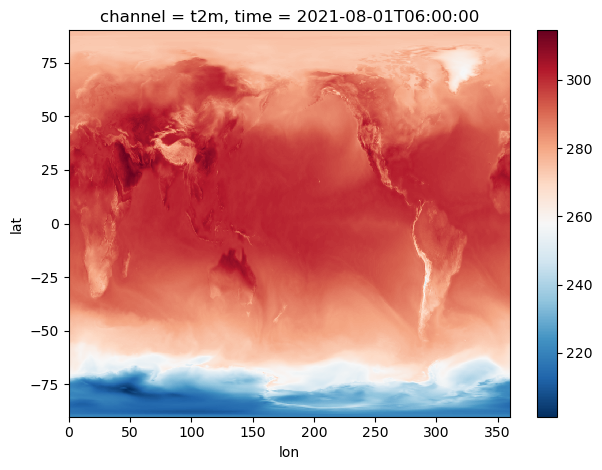

In [38]:
fig, ax = plt.subplots()
ds.sel(channel="t2m").isel(time=1).squeeze().plot.pcolormesh(ax=ax, cmap="RdBu_r")
plt.tight_layout()
plt.show()

## Compare: CDS Dataset

In [39]:
data_source = cds.DataSource(time_loop.in_channel_names)

In [40]:
%%time
ds_cds = run_basic_inference(
    time_loop, 
    n=num_steps, 
    data_source=data_source, 
    time=t0
)

CPU times: user 4.55 s, sys: 33.3 s, total: 37.8 s
Wall time: 50.4 s


Below, we calculate the difference between the two fields: 
1. field 1 generated by data we downloaded manually and saved
2. field 2 generated by data we downloaded via the CDSAPI

In [41]:

# calculate the difference
diff_t2m = np.abs(ds.sel(channel="t2m") - ds_cds.sel(channel="t2m")).mean()

In [42]:
diff_t2m.values

array(0., dtype=float32)

In [43]:
from pathlib import Path

save_dir = Path("/pool/proyectos/CLINT/temp/sa4attrs/data/pred/earth2mip")
save_name = f"{model_name.replace('_','')}"
save_name += f"-{str(t0.date()).replace('-','')}"
save_name += ".nc"
save_name = save_name.replace('-','_')
save_dir = save_dir.joinpath(save_name)
save_dir

PosixPath('/pool/proyectos/CLINT/temp/sa4attrs/data/pred/earth2mip/fcnv2sm_20210801.nc')

In [23]:
# ds.to_netcdf()